In [1]:
%pip install pandas seaborn matplotlib 

You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Data Preprocessing

#### 1. Combine NBA Draft Ranking and their Draft Combine Stats

In [2]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_dir = current_dir.parent / "drafts"

files = list(draft_dir.glob("draft_20*.csv"))

draft_df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    draft_df = pd.concat([draft_df, curr_df])

draft_df = draft_df.sort_values(by=["SEASON", "OVERALL_PICK"]) 
draft_df.head()

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE,PLAYER_PROFILE_FLAG
0,2030,Kenyon Martin,2000,1,1,1,Draft,1610612751,New Jersey,Nets,NJN,Cincinnati,College/University,1
1,2031,Stromile Swift,2000,1,2,2,Draft,1610612763,Vancouver,Grizzlies,VAN,Louisiana State,College/University,1
2,2032,Darius Miles,2000,1,3,3,Draft,1610612746,Los Angeles,Clippers,LAC,East St. Louis,High School,1
3,2033,Marcus Fizer,2000,1,4,4,Draft,1610612741,Chicago,Bulls,CHI,Iowa State,College/University,1
4,2034,Mike Miller,2000,1,5,5,Draft,1610612753,Orlando,Magic,ORL,Florida,College/University,1


In [3]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_combine_dir = current_dir.parent / "draft_combine"

files = list(draft_combine_dir.glob("draft_combine_20*.csv"))

draft_combine_df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    draft_combine_df = pd.concat([draft_combine_df, curr_df])

draft_combine_df = draft_combine_df.sort_values(by=["SEASON"])
draft_combine_df.head()

,SEASON,PLAYER_ID,FIRST_NAME,LAST_NAME,PLAYER_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,...,SPOT_NBA_BREAK_RIGHT,SPOT_NBA_CORNER_RIGHT,OFF_DRIB_FIFTEEN_BREAK_LEFT,OFF_DRIB_FIFTEEN_TOP_KEY,OFF_DRIB_FIFTEEN_BREAK_RIGHT,OFF_DRIB_COLLEGE_BREAK_LEFT,OFF_DRIB_COLLEGE_TOP_KEY,OFF_DRIB_COLLEGE_BREAK_RIGHT,ON_MOVE_FIFTEEN,ON_MOVE_COLLEGE
10,2000,2037,Jamal,Crawford,Jamal Crawford,PG-SG,76.5,6' 4.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,2000,2058,Mark,Madsen,Mark Madsen,PF,80.0,6' 8'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2000,2090,Justin,Love,Justin Love,PG-SG,73.5,6' 1.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2000,2061,Dan,Langhi,Dan Langhi,SF,81.0,6' 9'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,2000,12144,Brandon,Kurtz,Brandon Kurtz,PF-C,81.5,6' 9.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
merged_df = pd.merge(
    draft_df,
    draft_combine_df,              
    left_on=["PERSON_ID", "SEASON"],
    right_on=["PLAYER_ID", "SEASON"],
    how="left",                     # ⬅️ keep ALL rows from draft_df
    suffixes=("_DRAFT", "_COMBINE")
)

# Remove duplicates if any
merged_df = merged_df.drop_duplicates()

# Sort by season and draft order
merged_df = merged_df.sort_values(by=["SEASON", "OVERALL_PICK"])
merged_df.head()

,PERSON_ID,PLAYER_NAME_DRAFT,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,DRAFT_TYPE,TEAM_ID,TEAM_CITY,TEAM_NAME,...,SPOT_NBA_BREAK_RIGHT,SPOT_NBA_CORNER_RIGHT,OFF_DRIB_FIFTEEN_BREAK_LEFT,OFF_DRIB_FIFTEEN_TOP_KEY,OFF_DRIB_FIFTEEN_BREAK_RIGHT,OFF_DRIB_COLLEGE_BREAK_LEFT,OFF_DRIB_COLLEGE_TOP_KEY,OFF_DRIB_COLLEGE_BREAK_RIGHT,ON_MOVE_FIFTEEN,ON_MOVE_COLLEGE
0,2030,Kenyon Martin,2000,1,1,1,Draft,1610612751,New Jersey,Nets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2031,Stromile Swift,2000,1,2,2,Draft,1610612763,Vancouver,Grizzlies,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2032,Darius Miles,2000,1,3,3,Draft,1610612746,Los Angeles,Clippers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2033,Marcus Fizer,2000,1,4,4,Draft,1610612741,Chicago,Bulls,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2034,Mike Miller,2000,1,5,5,Draft,1610612753,Orlando,Magic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


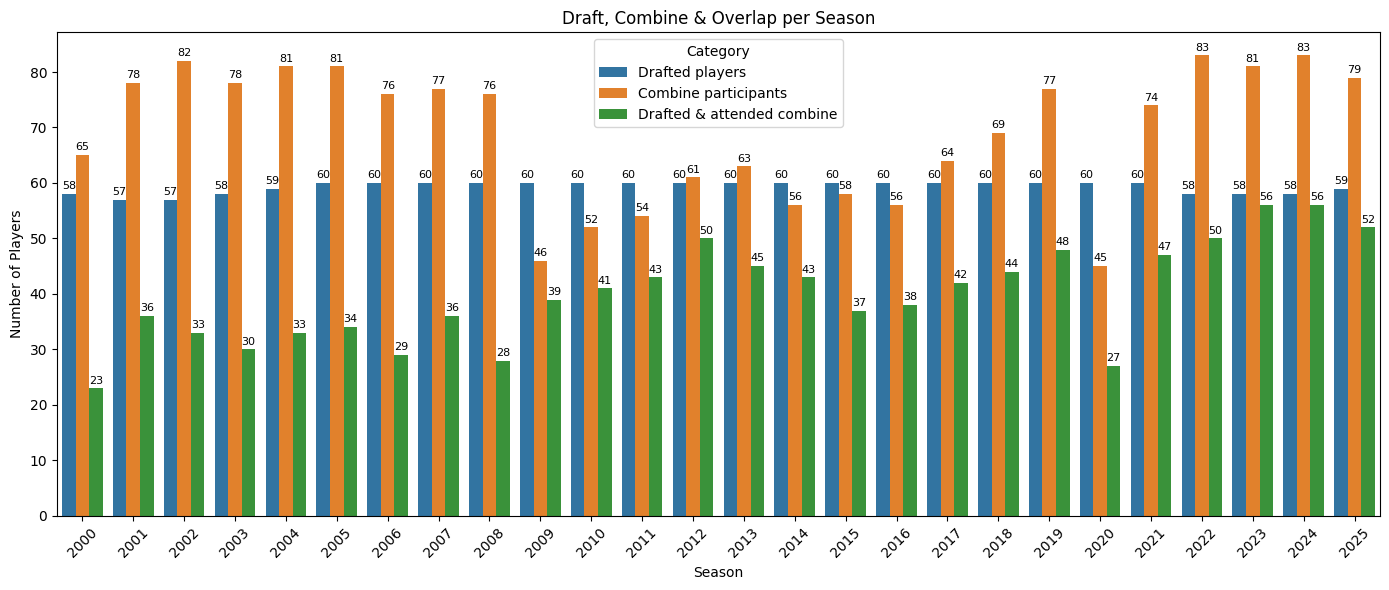

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Counts per season
drafted_counts = (
    draft_df.groupby("SEASON")["PERSON_ID"]
    .nunique()
    .rename("Drafted players")
)

combine_counts = (
    draft_combine_df.groupby("SEASON")["PLAYER_ID"]
    .nunique()
    .rename("Combine participants")
)

drafted_and_combine_counts = (
    merged_df.groupby("SEASON")["PLAYER_ID"]
    .nunique()
    .rename("Drafted & attended combine")
)

# 2) Combine into one DataFrame
counts_per_season = (
    pd.concat(
        [drafted_counts, combine_counts, drafted_and_combine_counts],
        axis=1
    )
    .reset_index()
    .sort_values("SEASON")
)

# 3) Long format for seaborn
plot_df = counts_per_season.melt(
    id_vars="SEASON",
    value_vars=[
        "Drafted players",
        "Combine participants",
        "Drafted & attended combine",
    ],
    var_name="Category",
    value_name="Count",
)

# 4) Plot grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    data=plot_df,
    x="SEASON",
    y="Count",
    hue="Category",
    ax=ax
)

ax.set_title("Draft, Combine & Overlap per Season")
ax.set_xlabel("Season")
ax.set_ylabel("Number of Players")
plt.xticks(rotation=45)

# Optional: label bars with values (matplotlib ≥ 3.4)
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=2, fontsize=8)

plt.tight_layout()
plt.show()


#### 2. Drop and Rename Columns

In [6]:
df = merged_df.copy()

In [7]:
# Remove redundant name columns
cols_to_drop = [
    "PLAYER_ID",

    "FIRST_NAME",
    "LAST_NAME",
    "PLAYER_NAME_COMBINE",

    "ROUND_PICK",

    "HEIGHT_W_SHOES",
    "HEIGHT_W_SHOES_FT_IN",
    "HEIGHT_WO_SHOES_FT_IN",

    "WINGSPAN_FT_IN",
    "STANDING_REACH_FT_IN",
    "STANDING_REACH",

    "DRAFT_TYPE",

    "TEAM_ID",
    "TEAM_CITY",
    "TEAM_ABBREVIATION"

]
df = df.drop(columns=cols_to_drop)


rename_map = {}

if "PLAYER_NAME_DRAFT" in df.columns:
    rename_map["PLAYER_NAME_DRAFT"] = "PLAYER_NAME"

# --- Rename height column ---
if "HEIGHT_WO_SHOES" in df.columns:
    rename_map["HEIGHT_WO_SHOES"] = "HEIGHT"

# Apply renaming once
if rename_map:
    df = df.rename(columns=rename_map)


In [8]:
df.columns

Index(['PERSON_ID', 'PLAYER_NAME', 'SEASON', 'ROUND_NUMBER', 'OVERALL_PICK',
       'TEAM_NAME', 'ORGANIZATION', 'ORGANIZATION_TYPE', 'PLAYER_PROFILE_FLAG',
       'POSITION', 'HEIGHT', 'WEIGHT', 'WINGSPAN', 'BODY_FAT_PCT',
       'HAND_LENGTH', 'HAND_WIDTH', 'STANDING_VERTICAL_LEAP',
       'MAX_VERTICAL_LEAP', 'LANE_AGILITY_TIME', 'MODIFIED_LANE_AGILITY_TIME',
       'THREE_QUARTER_SPRINT', 'BENCH_PRESS', 'SPOT_FIFTEEN_CORNER_LEFT',
       'SPOT_FIFTEEN_BREAK_LEFT', 'SPOT_FIFTEEN_TOP_KEY',
       'SPOT_FIFTEEN_BREAK_RIGHT', 'SPOT_FIFTEEN_CORNER_RIGHT',
       'SPOT_COLLEGE_CORNER_LEFT', 'SPOT_COLLEGE_BREAK_LEFT',
       'SPOT_COLLEGE_TOP_KEY', 'SPOT_COLLEGE_BREAK_RIGHT',
       'SPOT_COLLEGE_CORNER_RIGHT', 'SPOT_NBA_CORNER_LEFT',
       'SPOT_NBA_BREAK_LEFT', 'SPOT_NBA_TOP_KEY', 'SPOT_NBA_BREAK_RIGHT',
       'SPOT_NBA_CORNER_RIGHT', 'OFF_DRIB_FIFTEEN_BREAK_LEFT',
       'OFF_DRIB_FIFTEEN_TOP_KEY', 'OFF_DRIB_FIFTEEN_BREAK_RIGHT',
       'OFF_DRIB_COLLEGE_BREAK_LEFT', 'OFF_DRIB_COLLEG

#### 2. Missing Data Analysis

In [9]:
## missing values report

def missing_report(dataframe):
    report = (
        dataframe.isna()
        .sum()
        .to_frame("missing_count")
    )
    report["total_rows"] = len(dataframe)
    report["missing_percent"] = (report["missing_count"] / report["total_rows"]) * 100
    report["non_missing_count"] = report["total_rows"] - report["missing_count"]

    return report[[
        "missing_count",
        "non_missing_count",
        "missing_percent"
    ]].sort_values("missing_percent", ascending=False)


missing_report(df)

,missing_count,non_missing_count,missing_percent
OFF_DRIB_COLLEGE_BREAK_RIGHT,1529,13,99.156939
OFF_DRIB_COLLEGE_TOP_KEY,1529,13,99.156939
SPOT_FIFTEEN_CORNER_LEFT,1487,55,96.433204
SPOT_FIFTEEN_BREAK_LEFT,1486,56,96.368353
SPOT_FIFTEEN_BREAK_RIGHT,1486,56,96.368353
SPOT_FIFTEEN_CORNER_RIGHT,1486,56,96.368353
SPOT_FIFTEEN_TOP_KEY,1486,56,96.368353
SPOT_COLLEGE_CORNER_RIGHT,1446,96,93.774319
SPOT_COLLEGE_BREAK_RIGHT,1446,96,93.774319
SPOT_COLLEGE_TOP_KEY,1446,96,93.774319


In [10]:
# Drop columns with more than 90% missing values
df = df.drop(columns=[col for col in df.columns
                      if df[col].isna().mean() > 0.80])
                      

missing_report(df)

,missing_count,non_missing_count,missing_percent
MODIFIED_LANE_AGILITY_TIME,1128,414,73.151751
BENCH_PRESS,968,574,62.775616
HAND_WIDTH,863,679,55.966278
HAND_LENGTH,863,679,55.966278
BODY_FAT_PCT,789,753,51.167315
LANE_AGILITY_TIME,682,860,44.228275
THREE_QUARTER_SPRINT,678,864,43.968872
MAX_VERTICAL_LEAP,677,865,43.904021
STANDING_VERTICAL_LEAP,676,866,43.839170
WEIGHT,546,996,35.408560


#### 3.Feature Engineering

In [11]:
# Purpose: ensure numeric columns are true numbers (floats/ints), not strings

numeric_cols = [
    "HEIGHT", "WEIGHT", "WINGSPAN",
    "STANDING_REACH", "BODY_FAT_PCT", "HAND_LENGTH", "HAND_WIDTH",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "MODIFIED_LANE_AGILITY_TIME",
    "THREE_QUARTER_SPRINT", "BENCH_PRESS",
    "ROUND_NUMBER", "OVERALL_PICK"
]
existing_numeric_cols = [c for c in numeric_cols if c in df.columns]
df[existing_numeric_cols] = df[existing_numeric_cols].apply(pd.to_numeric, errors="coerce")

df[existing_numeric_cols].dtypes

HEIGHT                        float64
WEIGHT                        float64
WINGSPAN                      float64
BODY_FAT_PCT                  float64
HAND_LENGTH                   float64
HAND_WIDTH                    float64
STANDING_VERTICAL_LEAP        float64
MAX_VERTICAL_LEAP             float64
LANE_AGILITY_TIME             float64
MODIFIED_LANE_AGILITY_TIME    float64
THREE_QUARTER_SPRINT          float64
BENCH_PRESS                   float64
ROUND_NUMBER                    int64
OVERALL_PICK                    int64
dtype: object

In [12]:
# Purpose: add useful derived features for downstream analysis or modeling

# BMI = weight (lb) / height^2 (in^2) * 703, using HEIGHT_W_SHOES_INCHES if available
if {"WEIGHT", "HEIGHT"}.issubset(df.columns):
    df["BMI"] = (df["WEIGHT"] / (df["HEIGHT"] ** 2)) * 703

# Vertical ratio: leap relative to height without shoes
if {"MAX_VERTICAL_LEAP", "HEIGHT"}.issubset(df.columns):
    df["VERTICAL_RATIO"] = df["MAX_VERTICAL_LEAP"] / df["HEIGHT"]

In [13]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# --- Priority order for detailed positions ---
position_priority = ["PG", "SG", "SF", "PF", "C"]
position_rank = {p: i for i, p in enumerate(position_priority)}

# --- Detailed → Broad mapping ---
group_map = {
    "PG": "G",
    "SG": "G",
    "SF": "F",
    "PF": "F",
    "C":  "C"
}

def normalize_position(pos):
    """Clean POSITION → PG/SG/SF/PF/C → then map to G/F/C."""
    if pd.isna(pos):
        return None
    # Split on any separator
    parts = re.split(r'[-/, ]+', str(pos).upper())
    # Keep valid basketball positions only
    parts = [p for p in parts if p in position_rank]
    if not parts:
        return None
    # Pick the primary position (highest priority)
    detailed = min(parts, key=lambda x: position_rank[x])
    # Map detailed → broad group (G/F/C)
    return group_map[detailed]

# --- Overwrite df["POSITION"] with G/F/C ---
df["POSITION"] = df["POSITION"].apply(normalize_position)

### 4. Feature Correlation

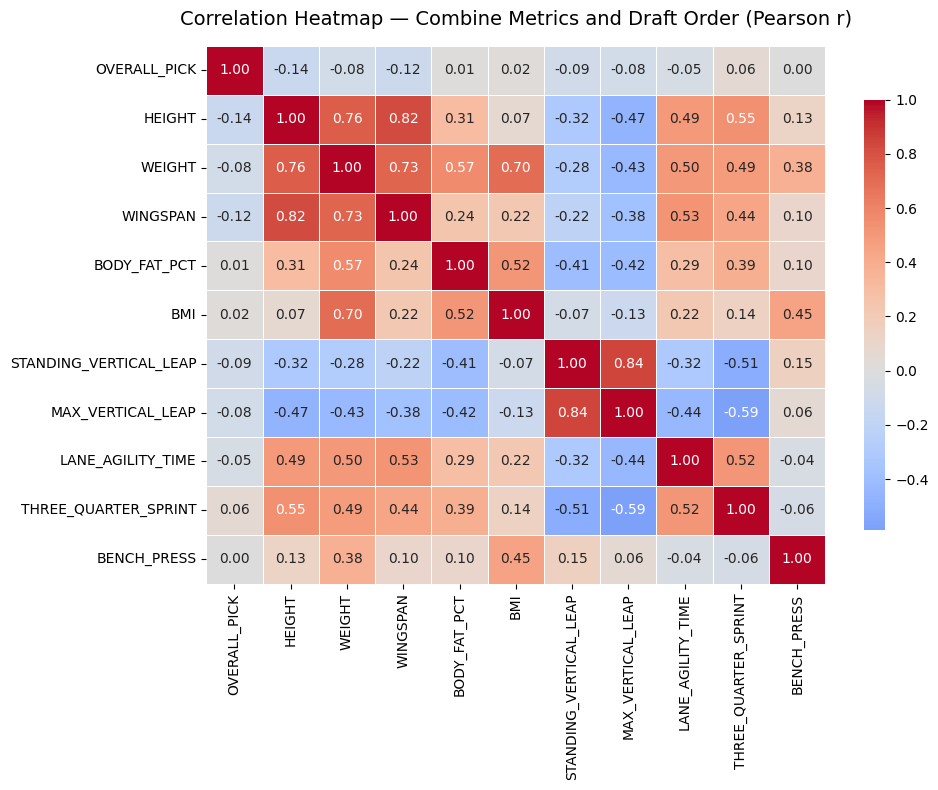

In [14]:
# Purpose: visualize overall correlation structure among key combine metrics and draft order
# (lower OVERALL_PICK = better player)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Select meaningful features ---
corr_features = [
    "OVERALL_PICK",
    "HEIGHT", "HEIGHT_CM", "WEIGHT", "WINGSPAN",
    "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]

# --- Filter to existing columns ---
corr_features = [c for c in corr_features if c in df.columns]
corr_df = df[corr_features].dropna()

# --- Compute correlation matrix ---
corr_matrix = corr_df.corr(numeric_only=True)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap — Combine Metrics and Draft Order (Pearson r)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

- Size metrics (height, weight, wingspan) correlate strongly with each other but weakly with draft order.  
- Body fat shows slight positive relation with later picks.  
- Overall, combine stats show little linear link to draft position.

/var/folders/b9/7xp5dt9d5nd0hct357z94wgh0000gn/T/ipykernel_28462/1720390725.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["SEASON", "POSITION"])["OVERALL_PICK"]


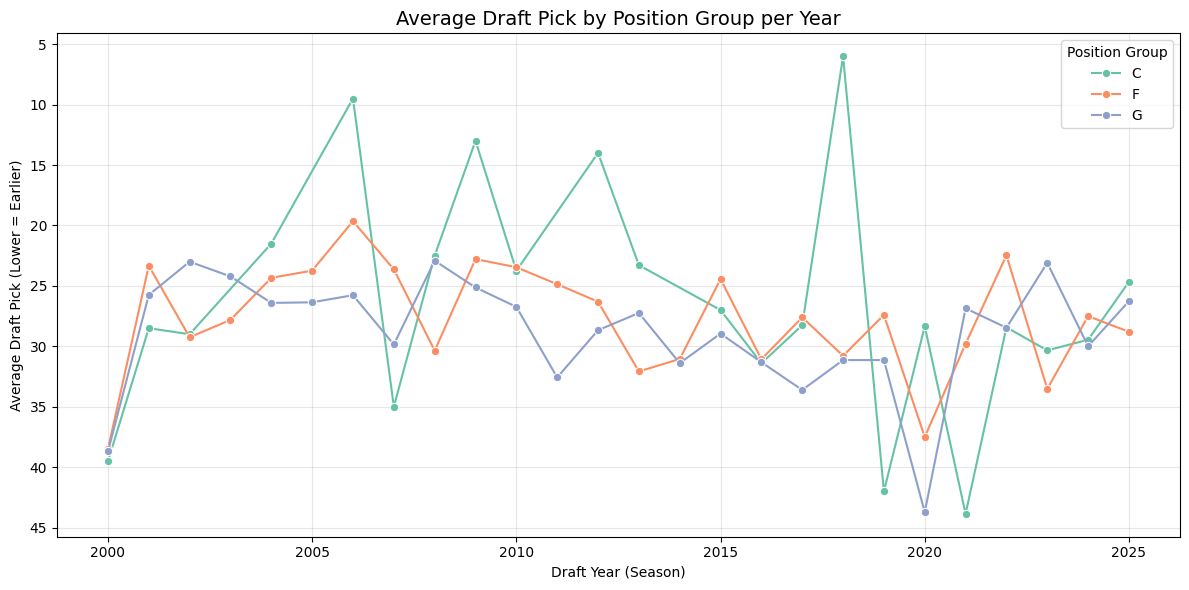

In [15]:
# Purpose: Plot average draft pick by position group across seasons

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure data types
df["SEASON"] = pd.to_numeric(df["SEASON"], errors="coerce")
df["POSITION"] = df["POSITION"].astype("category")

# --- Compute yearly averages ---
avg_pick_yearly = (
    df.groupby(["SEASON", "POSITION"])["OVERALL_PICK"]
    .mean()
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_pick_yearly,
    x="SEASON", y="OVERALL_PICK", hue="POSITION",
    marker="o", palette="Set2"
)
plt.gca().invert_yaxis()  # lower pick = better
plt.title("Average Draft Pick by Position Group per Year", fontsize=14)
plt.xlabel("Draft Year (Season)")
plt.ylabel("Average Draft Pick (Lower = Earlier)")
plt.legend(title="Position Group", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Across seasons, the average draft pick positions for Guards (G), Forwards (F), and Centers (C) fluctuate but follow a consistent pattern — Guards (G) are generally drafted earlier, followed closely by Forwards (F), while Centers (C) show greater variability and occasional peaks of earlier selections (e.g., years with standout big men).
This suggests that backcourt players tend to be prioritized more consistently, while the demand for Centers varies by draft class strength and team needs.